Groundwater | Case Study

# Topic 4 : Model implementation

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

In [1]:
# Import libraries
# Import libraries
import sys
import os
import time
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.affinity import rotate, translate
from scipy.interpolate import griddata
from affine import Affine

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import flopy
from flopy.discretization import StructuredGrid
from flopy.utils import Raster, GridIntersect

# Add the support repo to the path
sys.path.append('../')
sys.path.append('../SUPPORT_REPO/src')
sys.path.append('../SUPPORT_REPO/src/scripts/scripts_exercises')

# Import local modules
from data_utils import download_named_file, get_default_data_folder

# From Concept to Code: Implementing the Limmat Valley Model

In the previous steps, we defined our modeling objectives and developed a perceptual model of the Limmat Valley aquifer. We gathered data on the aquifer's geometry, its boundaries, and the key hydrological processes like recharge and river interaction.

Now, we will translate this perceptual understanding into a numerical groundwater model using **MODFLOW 2005** and the Python package **FloPy**. This process involves several key steps:

1.  **Discretization:** Defining the model grid (layers, rows, columns) that will represent our aquifer in space.
2.  **Parameterization:** Assigning hydraulic properties (like conductivity and storage) to the grid cells.
3.  **Boundary Conditions:** Implementing the physical boundaries of our system, such as rivers, recharge, and wells.
4.  **Solving:** Choosing a numerical solver and running the simulation.
5.  **Post-processing:** Visualizing and analyzing the initial results.

Let's begin by setting up our model workspace.

In [2]:
# --- 1. Model Setup and Workspace ---
# Define the name of our model and the workspace where files will be stored.
model_name = 'limmat_valley_model'
workspace = os.path.join(get_default_data_folder(), model_name)

# Create the workspace directory if it doesn't exist
os.makedirs(workspace, exist_ok=True)

# Define the path to the MODFLOW executable
# This path might be different on your system.
# We assume it's in a standard location accessible from the system's PATH.
executable = 'mf2005' 

# Create the MODFLOW model object
mf = flopy.modflow.Modflow(modelname=model_name, model_ws=workspace, exe_name=executable)

## Discretization: Building the Model Grid

The first step is to define the spatial domain of our model. Based on our perceptual model, we will create a single-layer model. The horizontal extent and resolution should be sufficient to cover our area of interest while keeping computation times reasonable.

We will use the Digital Elevation Model (DEM) from the perceptual model notebook to define the grid's extent and resolution.

limmat_model_boundary.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Model grid created with the following parameters:
xll:676711.6440121417; yll:246750.97989760104; rotation:0; crs:EPSG:21781; units:meters; lenuni:2


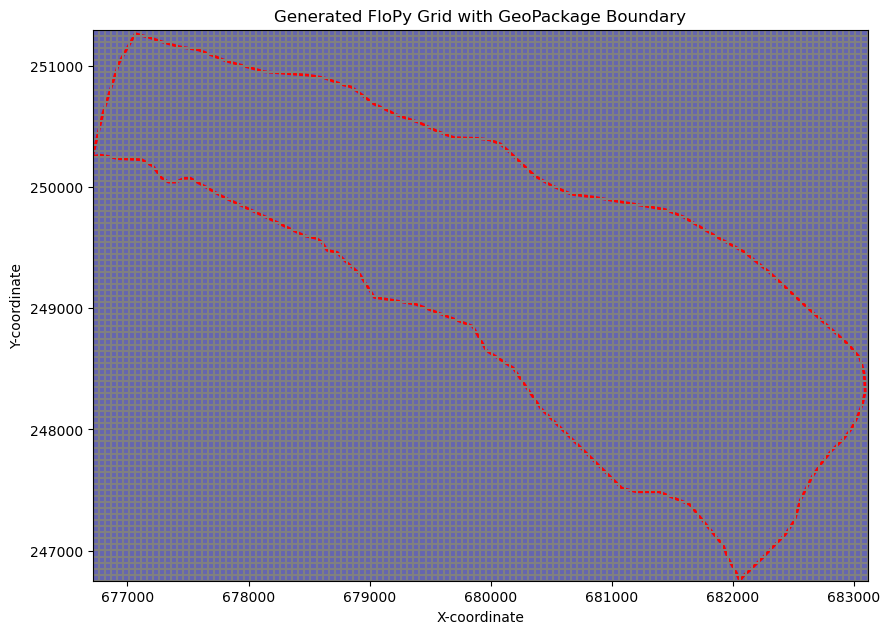

Total number of cells in the grid: 11648


In [3]:
# --- 2. Discretization (DIS Package) --- 
# Get the model boundary polygon
boundary_path = download_named_file(
    name='model_boundary',
    data_type='gis'
)
gdf = gpd.read_file(boundary_path)

# Get the bounding box of the geometry in your GeoPackage
# Assuming you want to use the total bounds of all geometries in the GeoPackage
xmin, ymin, xmax, ymax = gdf.total_bounds

# Rotation of the grid to minimize the number of cells. The grid is rotated 
# around the lower left corner (xll, yll).
rotation = 0  # degrees, adjust if needed

# Define grid dimensions
cell_size = 50  # meters

# Calculate number of rows and columns
ncol = int(np.ceil((xmax - xmin) / cell_size))
nrow = int(np.ceil((ymax - ymin) / cell_size))

# Define delr and delc (cell widths along rows and columns)
# For a regular grid, these will be arrays of the cell_size
delr = np.full(ncol, cell_size)
delc = np.full(nrow, cell_size)

# Define the origin of the grid (lower-left corner)
# FloPy by default assumes the origin (xll, yll) is the lower-left corner
xll = xmin
yll = ymin

# You'll also need to define the top and bottom of your model layers.
# For a basic grid creation, you can use dummy values.
# Let's assume a single layer for now.
nlay = 1

# We use dummy data for the top and the bottom elevation for now. We'll replace 
# these with actual data later.
top = np.ones((nrow, ncol)) * 100 # Example bottom elevation
botm = np.ones((nlay, nrow, ncol)) * 50 # Example bottom elevation

# Create ths structured grid object
modelgrid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=xll,
    yoff=yll,
    angrot=rotation,
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)
print("Model grid created with the following parameters:")
print(modelgrid)

# Plotting the grid (requires matplotlib)
fig, ax = plt.subplots(1, 1, figsize=(10, 10)) # Adjusted figsize to be more square if needed
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax) # Pass ax directly
pc = pmv.plot_array(modelgrid.top, alpha=0.5, cmap='terrain') # Added cmap for better visualization
pmv.plot_grid()

# Plot the GeoPackage boundary on top for verification
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

ax.set_title("Generated FloPy Grid with GeoPackage Boundary")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

# Count the number of cells in the grid
total_cells = ncol * nrow * nlay
print(f"Total number of cells in the grid: {total_cells}")


You will notice, that most of the cells are outside the model boundary. This is inefficient as the entire matrix will be solved, even if some cells are not part of the model. To reduce the number of cells in the model, we will rotate the model grid to align it with the model boundary. We will also need to buffer the model boundary by 10 meters to ensure that the grid cells cover the entire area of interest and to move the model origin (the lower left corner of the model) as the rotation of the grid will happen around the origin point.

limmat_model_boundary.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Model grid created with the following parameters:
xll:676170.9838663983; yll:249464.8648776182; rotation:-25; crs:EPSG:21781; units:meters; lenuni:2


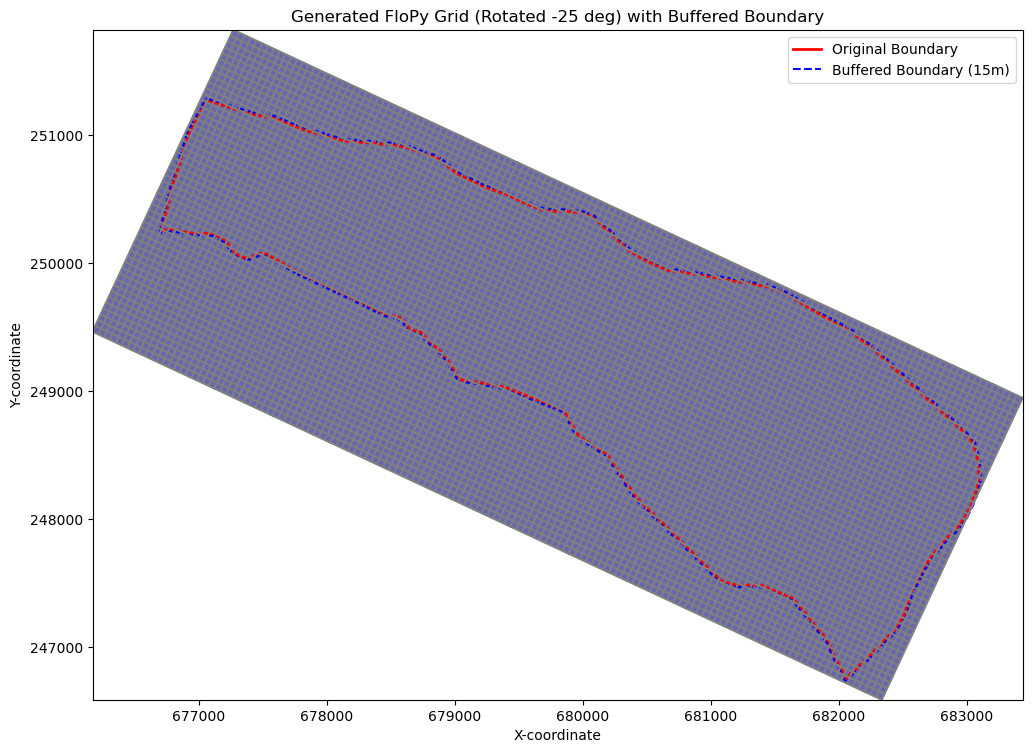

Total number of cells in the grid: 7072


In [4]:
# --- 2. Discretization (DIS Package) --- 
# Get the model boundary polygon
boundary_path = download_named_file(
    name='model_boundary',
    data_type='gis'
)
gdf = gpd.read_file(boundary_path)

# Buffer the model boundary polygon 
buffer_distance = 15  # meters (can be 10 or 25)
gdf_buffered = gdf.copy()
gdf_buffered.geometry = gdf.buffer(buffer_distance)

# Get the bounding box of the buffered geometry
# We'll use this as the initial extent for calculating nrow/ncol
xmin_buffered, ymin_buffered, xmax_buffered, ymax_buffered = gdf_buffered.total_bounds

# Desired grid rotation in degrees (negative for clockwise)
grid_rotation_angle = -25  # degrees, adjust if needed

# Define grid dimensions
cell_size = 50  # meters

# It's often simpler to rotate the *boundary* itself to find its new axis-aligned
# bounding box, and then derive the xoff/yoff for the *grid* that matches this.

# Get the geometry of the buffered boundary (assuming it's a single polygon for simplicity)
# If multiple polygons, you might need to dissolve them or iterate.
buffered_polygon = gdf_buffered.geometry.union_all() # Combine all geometries into one

# Rotate the buffered polygon around its own centroid for a first pass,
# to find the true extent needed for the rotated grid.
# This helps in finding the appropriate xll, yll for the rotated grid.
# Centroid as rotation origin helps keep the rotated shape "centered" relative 
# to its original space.
rotation_origin_x, rotation_origin_y = buffered_polygon.centroid.xy
rotation_origin = (rotation_origin_x[0], rotation_origin_y[0])

rotated_boundary_for_extent = rotate(
    buffered_polygon, -grid_rotation_angle, origin=rotation_origin, use_radians=False)

# Get the bounding box of the *rotated* boundary
xmin_rotated, ymin_rotated, xmax_rotated, ymax_rotated = rotated_boundary_for_extent.bounds

# Calculate nrow/ncol based on the rotated boundary's extent
# This ensures the grid is large enough to cover the rotated area
ncol_rotated = int(np.ceil((xmax_rotated - xmin_rotated) / cell_size))
nrow_rotated = int(np.ceil((ymax_rotated - ymin_rotated) / cell_size))

# Define delr and delc (cell widths along rows and columns) based on calculated dimensions
delr = np.full(ncol_rotated, cell_size)
delc = np.full(nrow_rotated, cell_size)

# The new origin (xoff, yoff) for the FloPy grid needs to be the lower-left corner
# of the *rotated* bounding box.
# We iteratively adjust the origin to ensure it aligns with the rotated extent.
xll_rotated = xmin_rotated - 300
yll_rotated = ymin_rotated + 1750 

# You'll also need to define the top and bottom of your model layers.
nlay = 1

# We use dummy data for the top and the bottom elevation for now. We'll replace 
# these with actual data later.
top = np.ones((nrow_rotated, ncol_rotated)) * 100 # Example top elevation
botm = np.ones((nlay, nrow_rotated, ncol_rotated)) * 50 # Example bottom elevation

# Create the structured grid object with the new origin and rotation
modelgrid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=xll_rotated, # Use the lower-left of the rotated extent
    yoff=yll_rotated, # Use the lower-left of the rotated extent
    angrot=grid_rotation_angle, # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)
print("Model grid created with the following parameters:")
print(modelgrid)

# Plotting the grid (requires matplotlib)
fig, ax = plt.subplots(1, 1, figsize=(12, 12)) # Adjust figsize for potentially larger/rotated extent
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(modelgrid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid()

# Plot the original and buffered GeoPackage boundaries on top for verification
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Original Boundary')
gdf_buffered.plot(ax=ax, facecolor='none', edgecolor='blue', linestyle='--', linewidth=1.5, label=f'Buffered Boundary ({buffer_distance}m)')

ax.set_title(f"Generated FloPy Grid (Rotated {grid_rotation_angle} deg) with Buffered Boundary")
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

# Create custom legend handles to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Original Boundary')
blue_line = mlines.Line2D([], [], color='blue', linestyle='--', linewidth=1.5, label=f'Buffered Boundary ({buffer_distance}m)')
ax.legend(handles=[red_line, blue_line])

plt.show()

total_cells = ncol_rotated * nrow_rotated * nlay
print(f"Total number of cells in the grid: {total_cells}")

By rotating the grid, we can reduce the number of model cells by about 30'000 cells, which will significantly speed up the model run time.

## Model Top
Now that we have the model grid, let's define the top of the model. The top of the model will be defined by the DEM, which we will use to create a single layer model. The DEM will have to be resampled on the model grid. 

dem_converted_bbox.tif already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.


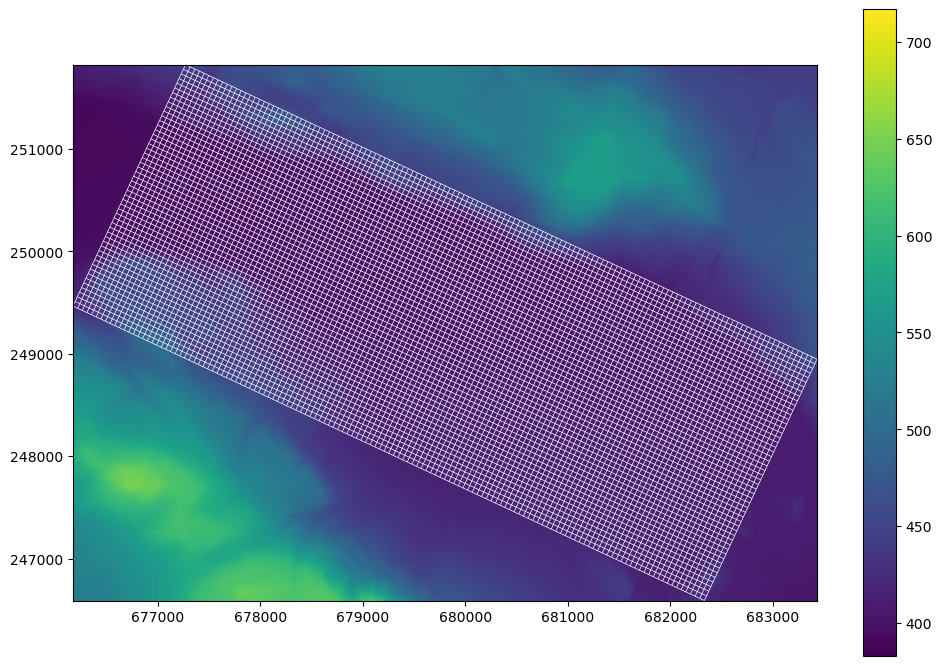

In [5]:
# Load the DEM data
dem_path = download_named_file(
    name='dem',
    data_type='gis'
)

# Assuming the DEM is in the same CRS as the model grid, we can resample it to match the grid.
rio = Raster.load(dem_path)

arr = rio.get_array(1)
idx = np.isfinite(arr)

vmin, vmax = arr[idx].min(), arr[idx].max()
vmin, vmax

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

ax = rio.plot(ax=ax, vmin=vmin, vmax=vmax)
plt.colorbar(ax.images[0], shrink=0.7)
pmv.plot_grid(ax=ax, lw=0.5, color="white")


Text(0, 0.5, 'Y-coordinate')

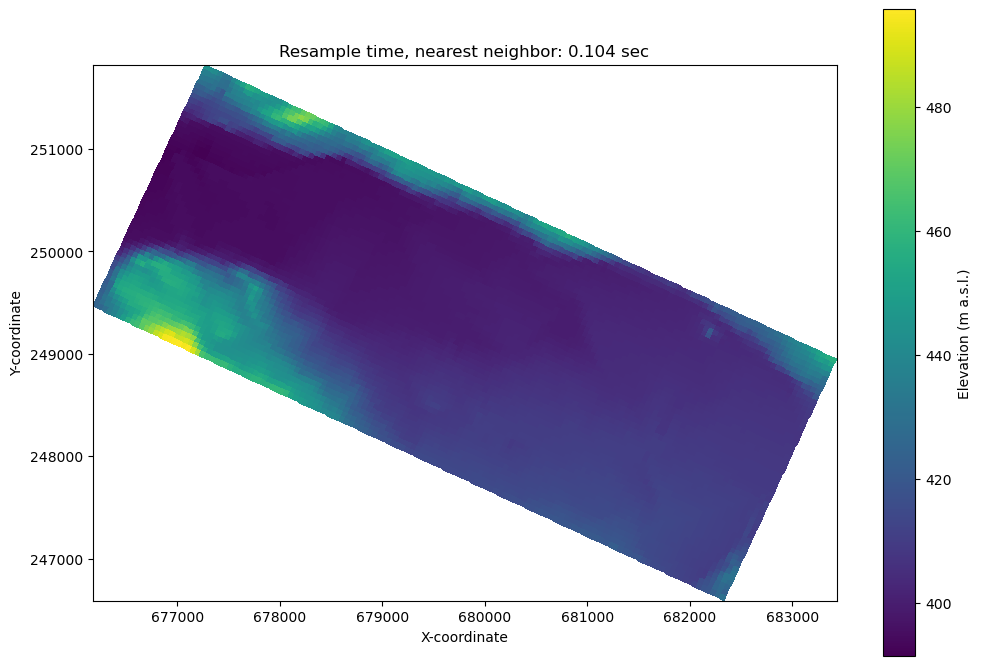

In [6]:
t0 = time.time()
model_top = rio.resample_to_grid(modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# We round to 10 centimeters to avoid having to store too many digits
model_top = np.round(model_top, 1)

# Update vmin and vmax based on the resampled data
vmin, vmax = model_top.min(), model_top.max()

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
ax = pmv.plot_array(model_top, masked_values=rio.nodatavals, vmin=vmin, vmax=vmax)
plt.title(f"Resample time, nearest neighbor: {resample_time:.3f} sec")
plt.colorbar(ax, shrink=0.7, label="Elevation (m a.s.l.)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

## Model Bottom

Next we tackle the bottom layer. The groundwater map of the canton of Zurich shows contour lines of the thickness of the aquifer for the deeper zones but for the shallower zones we see the range of the aquifer thickness. For the latter, we assume that the lower range corresponds to the contour line of the aquifer thickness. For the deeper zones, we will use the contour lines to define the bottom layer of the model. 

Grundwasservorkommen_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Deep contours (aquifer thickness in meters):
   LABEL  aquifer_thickness
0     30               30.0
1     40               40.0
2     50               50.0
3     60               60.0
4     60               60.0

Shallow contours (aquifer thickness in meters):
   GWLTYP  aquifer_thickness
0       6               20.0
1       4               10.0
2       2                2.0
4       1                2.0
5       1                2.0


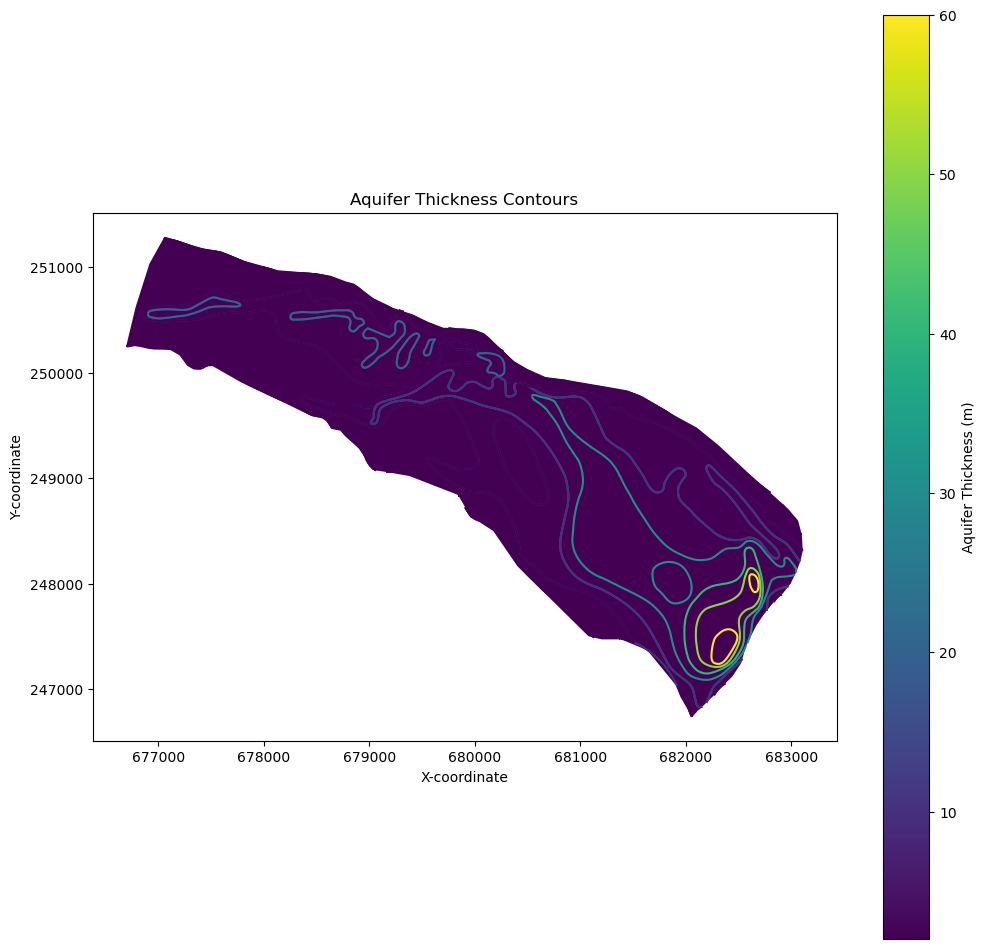

In [7]:
# a) Load the polygon layers with information about aqufier thickness.
gw_map_path = download_named_file(
    name='groundwater_map_norm', 
    data_type='gis', 
)

deep_contours_gdf = gpd.read_file(gw_map_path, layer="GS_GW_MAECHTIGKEIT_L")
shallow_gdf = gpd.read_file(gw_map_path, layer="GS_GW_LEITER_F") 

# Reproject the GeoDataFrames to match the model grid CRS
deep_contours_gdf = deep_contours_gdf.to_crs(modelgrid.crs)
shallow_gdf = shallow_gdf.to_crs(modelgrid.crs)

# For the deep contours, the aquifer thickness in meters is in the field 
# "LABEL". For the shallow contours, we have the field "GWLTYP" which corresponds 
# to a range of aquifer thickness. We have to manually assign a label attribute 
# here, using the GIS-Broswer as reference. 
# type_labels maps GWLTYP to the corresponding aquifer thickness in meters.
type_labels = {
        1: 2, 
        2: 2,
        4: 10,
        6: 20,
    }
# Create a new column 'aquifer_thickness' in shallow_gdf
shallow_gdf['aquifer_thickness'] = shallow_gdf['GWLTYP'].map(type_labels)

# Create a new column 'aquifer_thickness' in deep_contours_gdf
deep_contours_gdf['aquifer_thickness'] = deep_contours_gdf['LABEL'].astype(float)

# Discard rows in the shallow_gdf where aquifer_thickness is NaN
shallow_gdf = shallow_gdf.dropna(subset=['aquifer_thickness'])

# Now we need to make sure all shapes are available as lines. 
# Convert shallow polygons to contour lines by taking their boundaries
shallow_contours_gdf = shallow_gdf.copy()
shallow_contours_gdf.geometry = shallow_contours_gdf.geometry.boundary

# Define the buffered model boundary as a contour with 2m thickness
boundary_contour_gdf = gdf_buffered.copy()
boundary_contour_gdf['aquifer_thickness'] = 2.0

# View the first few rows of the deep contours and shallow contours
print("Deep contours (aquifer thickness in meters):")
print(deep_contours_gdf[['LABEL', 'aquifer_thickness']].head())
print("\nShallow contours (aquifer thickness in meters):")
print(shallow_gdf[['GWLTYP', 'aquifer_thickness']].head())

# Combine all contour dataframes into one
# We select only the 'aquifer_thickness' and 'geometry' columns to ensure consistency
all_contours_gdf = gpd.GeoDataFrame(
    pd.concat([
        deep_contours_gdf[['aquifer_thickness', 'geometry']],
        shallow_contours_gdf[['aquifer_thickness', 'geometry']],
        boundary_contour_gdf[['aquifer_thickness', 'geometry']]
    ], ignore_index=True),
    crs=gdf_buffered.crs
)

# Clip the contours to the model boundary polygon
clipped_gdf = gpd.clip(all_contours_gdf, gdf_buffered)

# Now we can plot the combined contours
fig, ax = plt.subplots(figsize=(12, 12))
clipped_gdf.plot(ax=ax, column='aquifer_thickness', cmap='viridis',
                 legend=True, legend_kwds={'label': "Aquifer Thickness (m)"})
ax.set_title("Aquifer Thickness Contours")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.show()

Now we need to subtract the aquifer thickness from the top of the model to define the bottom of the model. 

$$ \text{Bottom of the model} = \text{Top of the model} - \text{Aquifer thickness}$$

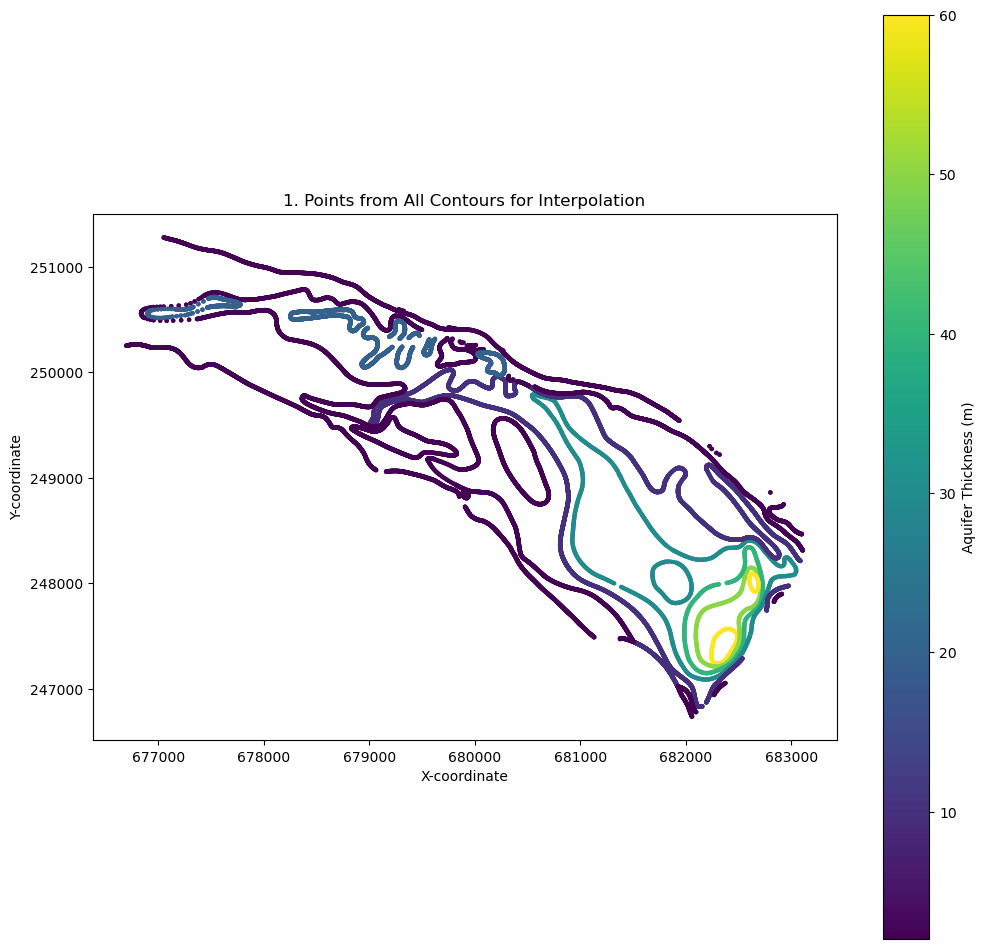

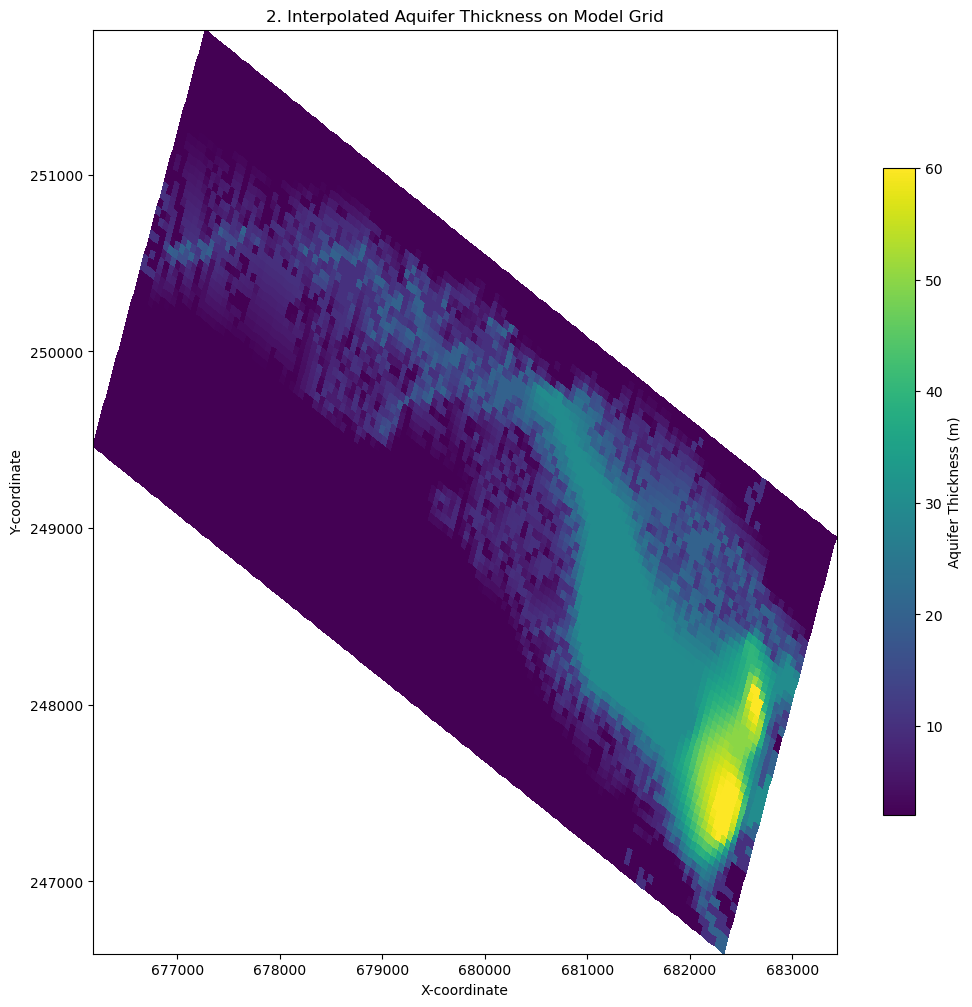

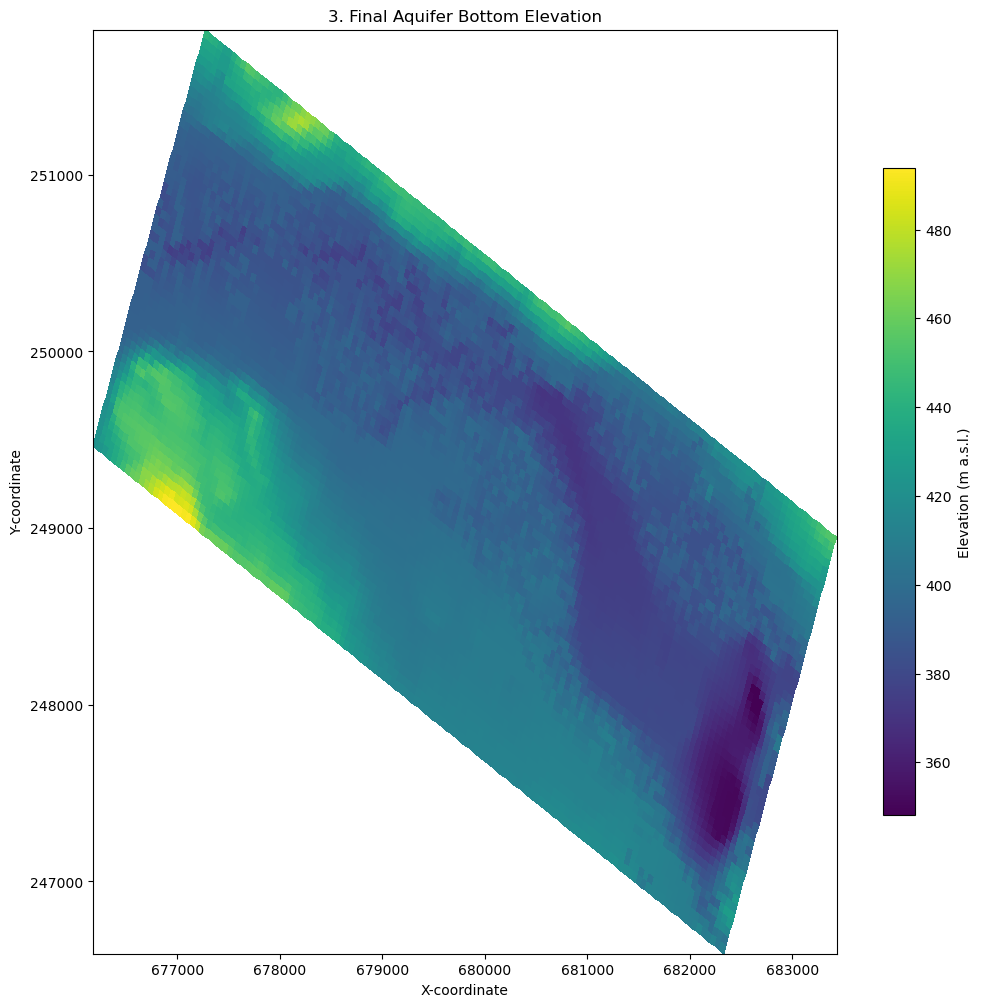

In [8]:
# Extract all points from the combined contour lines for interpolation
points_for_interp = []
for idx, row in clipped_gdf.iterrows():
    if row.geometry is None or row.geometry.is_empty:
        continue
    if row.geometry.geom_type == 'MultiLineString':
        for line in row.geometry.geoms:
            for x, y in line.coords:
                points_for_interp.append((x, y, row['aquifer_thickness']))
    elif row.geometry.geom_type == 'LineString':
        for x, y in row.geometry.coords:
            points_for_interp.append((x, y, row['aquifer_thickness']))

points_for_interp = np.array(points_for_interp)

# --- PLOT 1: Combined Contour Points ---
fig, ax = plt.subplots(figsize=(12, 12))
sc = ax.scatter(points_for_interp[:, 0], points_for_interp[:, 1], c=points_for_interp[:, 2], cmap='viridis', s=5)
plt.colorbar(sc, label='Aquifer Thickness (m)')
ax.set_title("1. Points from All Contours for Interpolation")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
plt.show()

# Interpolate directly onto the model grid cell centers
grid_x, grid_y = modelgrid.xcellcenters, modelgrid.ycellcenters

# First, use linear interpolation. This creates a smooth surface between contours.
aquifer_thickness_linear = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x, grid_y), 
    method='linear'
)

# Linear interpolation leaves NaNs outside the convex hull of the data.
# Fill these NaNs using nearest neighbor interpolation to cover the whole grid.
nan_indices = np.isnan(aquifer_thickness_linear)
aquifer_thickness_resampled = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x[nan_indices], grid_y[nan_indices]), 
    method='nearest'
)
aquifer_thickness_linear[nan_indices] = aquifer_thickness_resampled

# The final resampled grid
aquifer_thickness_resampled = aquifer_thickness_linear

# --- PLOT 2: Resampled Grid on Model Grid ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(aquifer_thickness_resampled)
plt.colorbar(im, shrink=0.7, label="Aquifer Thickness (m)")
ax.set_title("2. Interpolated Aquifer Thickness on Model Grid")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

# Subtract the aquifer thickness from the top of the model to define the bottom
model_bottom = model_top - aquifer_thickness_resampled

# Ensure the model bottom is a 3d array (nlay, nrow_rotated, ncol_rotated)
if model_bottom.ndim == 2:
    model_bottom = model_bottom[np.newaxis, :, :]  # Add a new axis for layers

# --- PLOT 3: Final Aquifer Bottom ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_bottom, vmin=np.nanmin(model_bottom), vmax=np.nanmax(model_bottom))
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
ax.set_title("3. Final Aquifer Bottom Elevation")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

Now we replace the dummy model top in the model object with our resampled DEM. This will ensure that the model top reflects the actual topography of the Limmat Valley. 


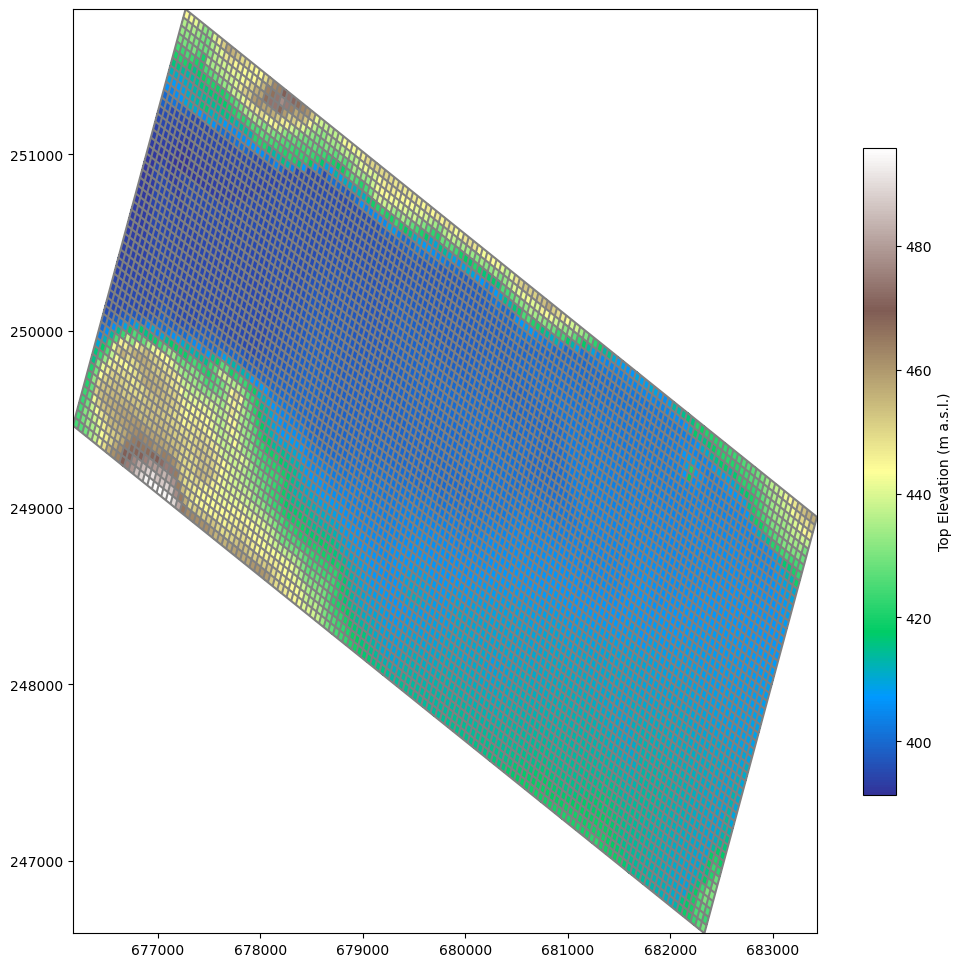

In [9]:
# Add new model top and bottom to the modelgrid
modelgrid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=model_top,
    botm=model_bottom,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    xoff=xll_rotated, # Use the lower-left of the rotated extent
    yoff=yll_rotated, # Use the lower-left of the rotated extent
    angrot=grid_rotation_angle, # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)

# Update the modelgrid in the MODFLOW model
mf.modelgrid = modelgrid

# Plot the mf modelgrid to verify
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
im = pmv.plot_array(mf.modelgrid.top, vmin=np.nanmin(mf.modelgrid.top), vmax=np.nanmax(mf.modelgrid.top), cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Top Elevation (m a.s.l.)")
pmv.plot_grid()

# Explicitly pass the grid parameters to the DIS package constructor.
# This will correctly set the nrow, ncol, etc. on the mf object.
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    delr=delr,
    delc=delc,
    top=model_top,
    botm=model_bottom,
    xoff=xll_rotated,
    yoff=yll_rotated,
    angrot=grid_rotation_angle,
    lenuni=2,
)

## Basic and Layer Properties (BAS & LPF Packages)

Next, we define the **Basic Package (BAS)**, which controls the status of each cell (active, inactive, or fixed-head) and sets the starting head values. For our initial model, we'll assume all cells within the aquifer boundary are active.

We also define the **Layer-Property Flow (LPF) Package**, where we assign hydraulic properties. As a first estimate, we'll use a uniform hydraulic conductivity based on literature values for gravel aquifers, as seen in Notebook 2.

In [ ]:
# --- 3. Basic Package (BAS) ---

# Pass the new grid object to GridIntersect
ix = GridIntersect(mf.modelgrid, method="vertex", rtree=True)
result = ix.intersect(Polygon(gdf.geometry.union_all()))

# Create a 2D idomain array first
idomain_2d = np.zeros((nrow_rotated, ncol_rotated), dtype=int)

# result.cellids is a list of (lay, row, col) tuples.
# We need to extract just the row and column indices for 2D indexing.
# We can do this by transposing the list of tuples and taking the last two elements.
if result.cellids.any():
    row_indices, col_indices = zip(*result.cellids)
    idomain_2d[row_indices, col_indices] = 1

# Add the layer dimension to create the final 3D idomain array
idomain = idomain_2d[np.newaxis, :, :]




# Set initial head values ('strt'). We'll start with heads 2 m below the top of the aquifer.
strt = np.copy(mf.modelgrid.top) - 2.0  # Initial head 2 m below the top

bas = flopy.modflow.ModflowBas(mf, ibound=idomain, strt=strt)

# Plot the initial head values
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)

# Plot the grid lines
pmv.plot_grid()

# Plot the ibound array to show the active model domain
pmv.plot_ibound()

# Create a copy of the starting heads array for plotting
#plot_strt = bas.strt.array.copy()
# Set heads in inactive cells to NaN so they are not plotted
#plot_strt[bas.ibound.array == 0] = np.nan

#im = pmv.plot_array(plot_strt)
#plt.colorbar(im, shrink=0.7, label="Initial Head (m a.s.l.)")
#ax.set_title("Initial Head Values in the Model Domain")
#plt.xlabel("X-coordinate")
#plt.ylabel("Y-coordinate")
#ax.set_aspect('equal', adjustable='box')  # Ensure equal aspect ratio
#plt.show()


# --- 4. Layer-Property Flow Package (LPF) ---
# Based on Freeze and Cherry (1979), a reasonable K for gravel is 10^-2 m/s.
# We convert this to m/day for our model units.
K_ms = 1e-2
K_mday = K_ms * 86400  # 86400 seconds in a day

hk = K_mday  # Horizontal hydraulic conductivity
vka = K_mday / 10 # Vertical hydraulic conductivity (common assumption)
sy = 0.15         # Specific yield
ss = 1e-5         # Specific storage

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=1)

ValueError: not enough values to unpack (expected 3, got 2)

## Solver and Output Control (PCG & OC Packages)

We need to tell MODFLOW how to solve the system of equations. The **Preconditioned Conjugate-Gradient (PCG)** package is a robust and commonly used solver. We also need to specify what results we want to save using the **Output Control (OC)** package.

In [ ]:
# --- 5. Solver and Output Control ---
# Add the PCG solver
pcg = flopy.modflow.ModflowPcg(mf, mxiter=50, iter1=30)

# Specify output control
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['print head', 'save head', 'save budget']})

## Writing Input Files and Running the Model

With all the packages defined, we can now write the input files to our workspace and run the MODFLOW simulation. FloPy handles the creation of all the necessary text files in the format MODFLOW expects.

In [ ]:
# --- 6. Write input files and run the model ---
try:
    # Write the model input files
    mf.write_input()

    # Run the model
    success, buff = mf.run_model(silent=False, report=True)

    if not success:
        raise Exception('MODFLOW did not terminate normally.')

except Exception as e:
    print(f"Model run failed: {e}")
    # Provide guidance if the executable is not found
    if "No such file or directory" in str(e):
        print("\n---")
        print("Tip: Make sure the MODFLOW executable (e.g., 'mf2005') is in your system's PATH,")
        print(f"or provide the full path to the 'executable' variable in the first code cell.")
        print("---")


## Initial Results: Visualizing the Head

After a successful run, MODFLOW creates output files containing the calculated heads and water budget. Let's load the head file and plot the results to see our first simulated groundwater table.

> 🤔 **Think about it**
> The model we just ran has no recharge, no rivers, and no wells. What do you expect the resulting groundwater head distribution to look like? Why?

In [ ]:
# --- 7. Post-Processing: Load and Plot Head Results ---
if success:
    # Create a head file object
    head_file = flopy.utils.HeadFile(os.path.join(workspace, f'{model_name}.hds'))
    # Get the head data for the first (and only) time step
    head = head_file.get_data(totim=1.0)

    # Plot the results
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')

    # Use the plot_results function from our utility script
    pu.plot_results(
        grid, 
        head[0, :, :], # Pass the 2D head array
        ax=ax, 
        title="Simulated Hydraulic Head (No Boundaries)",
        cbar_label="Hydraulic Head (m)",
        inactive_array=ibound[0,:,:] # Mask out inactive cells
    )
    
    plt.show()

As expected, without any inflows or outflows, the water table is flat. In the next notebooks, we will add the boundary conditions (recharge, rivers, wells) based on our perceptual model to create a more realistic